In [1]:
import numpy as np
import deepdish as dd
from brian2.only import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from SNN import SNN
from sweep import get_script
from grid_criticality import analysis_path, path_pr

import plot_utils as pu

In [2]:
delta_p = pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0)
ioi = 976
poi = delta_p.loc[ioi, 'p_inh']
roi = delta_p.loc[ioi, 'r_inh']
runseed = delta_p.loc[ioi, 'runseed']
net = delta_p.loc[ioi, 'net']

In [3]:
script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{path_pr(poi)}_rinh_{path_pr(roi)}_runseed_{runseed}')

# STDP

In [4]:
def excitatory_stdp(x):
    return 0.02 * np.where(x>0, np.exp(-x/20), -np.exp(x/20))
    if x > 0: 
        return 0.02 * np.exp(-x/20)
    else:
        return -0.02 * np.exp(x/20)

In [5]:
def inh_stdp(x):
    return 0.04 * (np.exp(-np.abs(x)/10) - 0.5 * np.exp(-np.abs(x)/20))

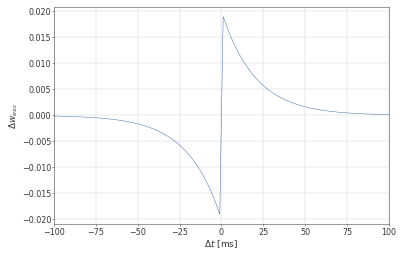

In [6]:
x=np.linspace(-100,100,100)
fig, ax = plt.subplots()
def plot_exc_stdp(ax, x=x):
    ax.plot(x, excitatory_stdp(x), c=pu.colors['exc'], label='Excitatory')
    ax.set_xlabel('$\Delta t$ [ms]')
    ax.set_ylabel('$\Delta w_{exc}$')
    # ax.set_xticks([-100,0,100])
    # ax.set_yticks([-0.02,0,0.02])
    ax.set_xlim(-100,100)
    ax.grid()
plot_exc_stdp(ax, x)

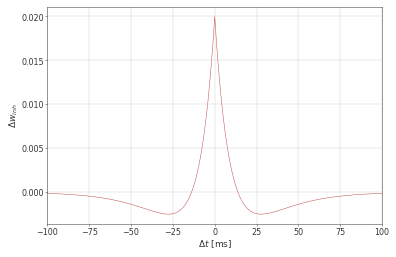

In [7]:
x=np.linspace(-100,100,201)
fig, ax = plt.subplots()
def plot_inh_stdp(ax, x=x):
    ax.plot(x, inh_stdp(x), c=pu.colors['inh'], label='Inhibitory')
    ax.set_xlabel('$\Delta t$ [ms]')
    ax.set_ylabel('$\Delta w_{inh}$')
    # ax.set_xticks([-100,0,100])
    # ax.set_yticks([0,0.02])
    ax.set_xlim(-100,100)
    ax.grid()
plot_inh_stdp(ax, x)

# Activity sample

In [8]:
snn = SNN(init_weights=False, **script.params, record_state=True)
snn.initialize_with(dd.io.load(f'{path}/maturation_0.h5'))

In [9]:
spikes = snn.run(2*second)
m = snn.get_state_monitor()

In [10]:
values, counts = np.unique(spikes[0], return_counts=True)
idx = values[np.argmax(counts)]
times = spikes[1][spikes[0]==idx]
tidx = (times / m.clock.dt + 0.5).astype(int)

In [11]:
t_initial, v_initial = m.t, m.v[idx]/mV
times_initial, tidx_initial = times, tidx

Text(0, 0.5, 'Voltage (mV)')

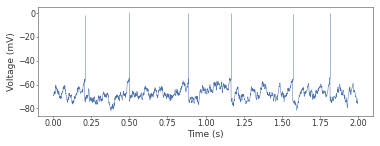

In [12]:
plt.figure(figsize=(6,2))
plt.plot(t_initial, v_initial)
plt.vlines(times_initial, v_initial[tidx_initial], v_initial[tidx_initial] + 55)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')

# Figure

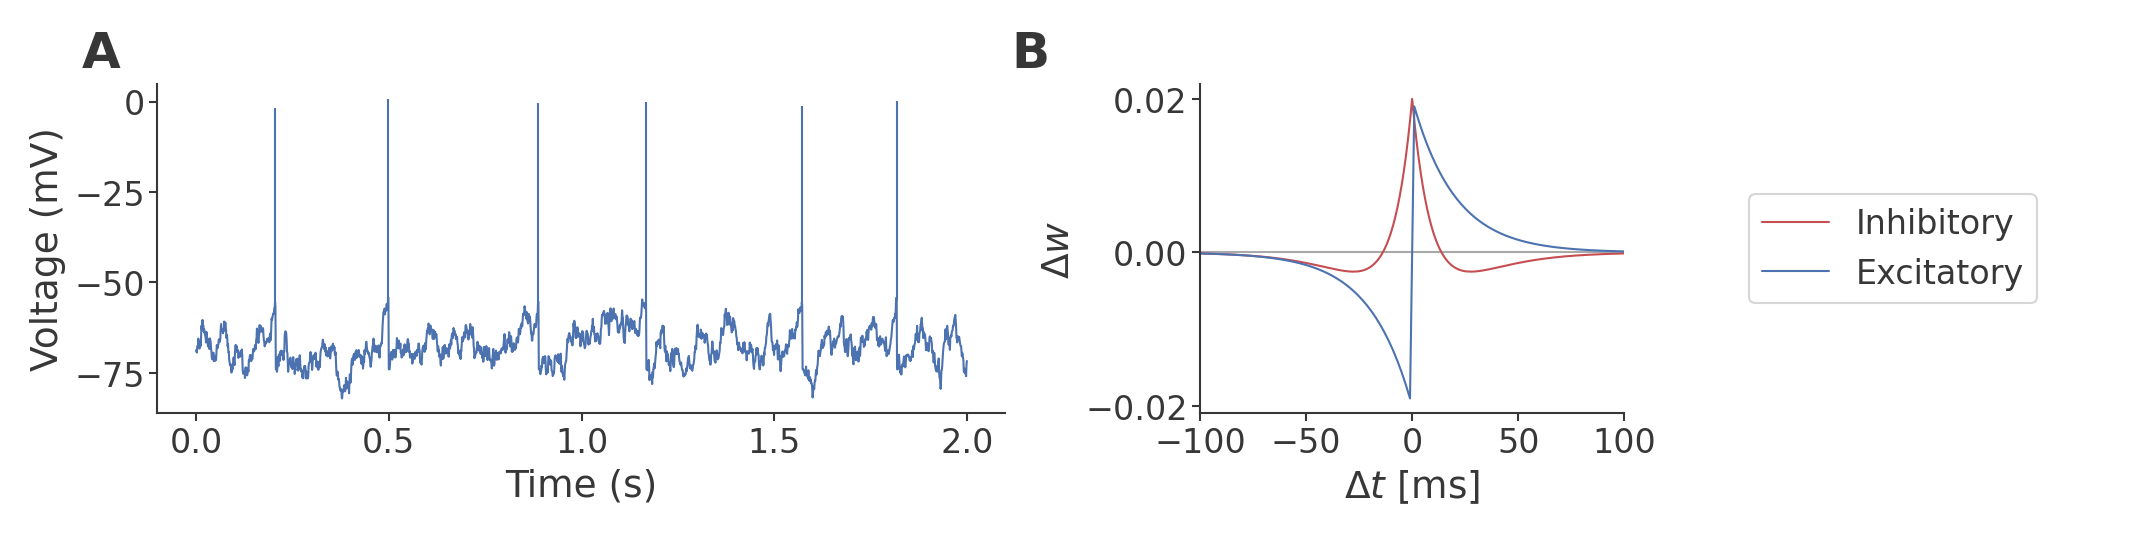

In [13]:
fig, axs = plt.subplots(1, 3, figsize=pu.fullwidth(1.5), facecolor='w', layout='compressed', width_ratios=(2,1,1), dpi=300)

axs[0].plot(t_initial, v_initial)
axs[0].vlines(times_initial, v_initial[tidx_initial], v_initial[tidx_initial] + 55)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Voltage (mV)')

axs[1].axhline(0, **pu.styling.axline_kwargs)
plot_inh_stdp(axs[1])
plot_exc_stdp(axs[1])
axs[1].set_ylabel('$\Delta w$')

axs[2].plot([], label='Inhibitory', c=pu.colors['inh'])
axs[2].plot([], label='Excitatory', c=pu.colors['exc'])
axs[2].axis('off')
axs[2].legend(loc='center')

pu.label_panel(axs[0], 0, left=0.5)
pu.label_panel(axs[1], 1)

sns.despine()

plt.savefig('Figure 1.tif', bbox_inches='tight')